In [13]:
import geopandas as gpd
import pandas as pd
from shapely.ops import voronoi_diagram
from keplergl import KeplerGl
import folium
import json

In [14]:
def coords_csv_to_gdf(colour):
  df = pd.read_csv(f"{colour}.csv", encoding="utf-8")
  df["colour"] = colour
  df["Coordinates"] = df["Coordinates"].apply(lambda coords: [ord for ord in str(coords).split()])
  split_lat_lon = pd.DataFrame(df["Coordinates"].tolist(), columns=["lat", "lon"])
  split_lat_lon["lat"] = split_lat_lon["lat"].apply(lambda x: x[:-2])
  split_lat_lon["lon"] = split_lat_lon["lon"].apply(lambda x: x[:-2] if x[-1] == "E" else f'-{x[:-2]}')
  combined = pd.concat([df, split_lat_lon], axis=1, join='inner')
  gdf = gpd.GeoDataFrame(combined, geometry=gpd.points_from_xy(combined.lon, combined.lat)).drop(["Coordinates", "OS grid", "lat", "lon"], axis=1)
  return gdf

In [15]:
white_gdf = coords_csv_to_gdf("white")
black_gdf = coords_csv_to_gdf("black")
black_and_white = black_gdf.append(white_gdf)
black_and_white = black_and_white.set_crs(epsg=4326)
black_and_white

,Location,Locality,colour,geometry
0,Blackawton,Devon,black,POINT (-3.68000 50.33000)
1,Black Bank,Cambridgeshire,black,POINT (0.24000 52.44000)
2,Black Bank,Warwickshire,black,POINT (-1.48000 52.47000)
3,Black Banks,Darlington,black,POINT (-1.55000 54.50000)
4,Black Barn,Lincolnshire,black,POINT (0.12000 52.83000)
...,...,...,...,...
159,Whiteway,Bath and North East Somerset,white,POINT (-2.41000 51.36000)
160,Whitewell,Cornwall,white,POINT (-4.75000 50.58000)
161,Whitewell,Lancashire,white,POINT (-2.53000 53.90000)
162,Whitewell,Wrexham,white,POINT (-2.76000 52.96000)


<AxesSubplot:>

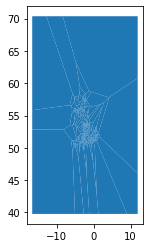

In [16]:
regions = black_and_white["geometry"].unary_union
voroni = {"geometry": voronoi_diagram(regions)}
voroni_gdf = gpd.GeoDataFrame(voroni, crs="EPSG:4326")
voroni_gdf.plot()

<AxesSubplot:>

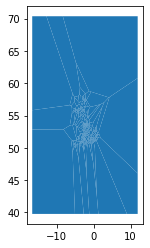

In [17]:
voroni_gdf = voroni_gdf.sjoin(black_and_white)
voroni_gdf.plot()

<AxesSubplot:>

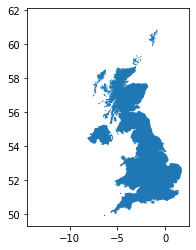

In [18]:
uk = gpd.read_file('uk_outline.geojson')
uk.plot()

In [21]:
config = json.load(open('config.json'))
map = KeplerGl(config=config)
map_layer_gdf = voroni_gdf.clip(uk)
map_layer_gdf.to_file("map_layer.geojson")
map.add_data(map_layer_gdf, name="Voroni")
map
# map = folium.Map()
# voroni_layer = folium.GeoJson(voroni_gdf.clip(uk).to_json())
# voroni_layer.add_to(map)
# map.fit_bounds(voroni_layer)
# map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'Voroni', 'type': '…